In [71]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree

import warnings
warnings.filterwarnings("ignore")

no display found. Using non-interactive Agg backend


In [2]:
pwd

"/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/Bella's Code"

In [3]:
data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/employee_retention_data.csv')
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

In [7]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [8]:
#### we notice that the seniority level has a maximum value 99, we need to check whether it's outlier

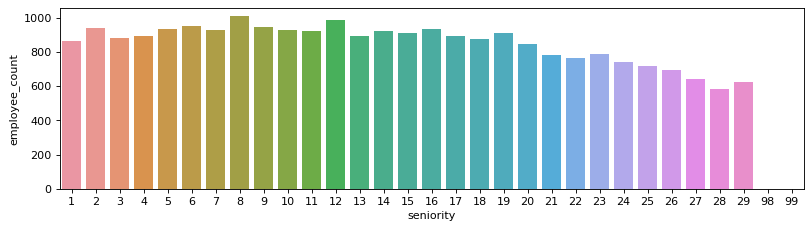

In [9]:
temp_data = data[['seniority', 'employee_id']].groupby(['seniority']).count().reset_index()
temp_data.columns = ['seniority', 'employee_count']
plt.figure(figsize = (12, 3), dpi = 80)
sns.barplot(data = temp_data, x = 'seniority', y = 'employee_count')

plt.show()

In [10]:
data = data[(data['seniority'] < 98)]

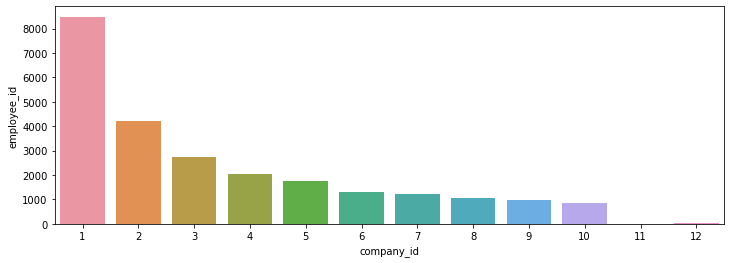

In [59]:
temp_data = data[['company_id', 'employee_id']].groupby(['company_id']).count().reset_index()
plt.figure(figsize = (12, 4))
sns.barplot(data = temp_data, x = 'company_id', y = 'employee_id')
plt.show()

###  Part 1 summerize each company's daily employees count

In [14]:
date_df = pd.DataFrame(pd.date_range(start='2011-01-24', end='2015-12-13'), columns = ['date'])
company_df = pd.DataFrame(data['company_id'].unique(), columns = ['company_id']).sort_values(by = ['company_id'])
part1_data = pd.merge(left = date_df, right = company_df, how = 'cross')
part1_data.head()

,date,company_id
0,2011-01-24,1
1,2011-01-24,2
2,2011-01-24,3
3,2011-01-24,4
4,2011-01-24,5


In [15]:
temp_data_join = data[['employee_id', 'company_id', 'join_date']].groupby(['join_date', 'company_id']).count().reset_index()
temp_data_quit = data[['employee_id', 'company_id', 'quit_date']].groupby(['quit_date', 'company_id']).count().reset_index()

In [16]:
part1_data = pd.merge(left = part1_data, 
                      right = temp_data_join, 
                      how = 'left', 
                      left_on = ['date', 'company_id'],
                      right_on = ['join_date', 'company_id'])
part1_data = pd.merge(left = part1_data, 
                      right = temp_data_quit, 
                      how = 'left', 
                      left_on = ['date', 'company_id'],
                      right_on = ['quit_date', 'company_id'])

In [17]:
part1_data.columns = ['date', 'company_id', 'join_date', 'join_employee_count',
                      'quit_date', 'quit_employee_count']

In [18]:
part1_data['quit_employee_count'] = part1_data['quit_employee_count'].replace(np.nan, 0)
part1_data['join_employee_count'] = part1_data['join_employee_count'].replace(np.nan, 0)

In [19]:
part1_data['net_add'] = part1_data['join_employee_count'] - part1_data['quit_employee_count']

In [20]:
part1_data['employee_headcount'] = part1_data.groupby('company_id')['net_add'].transform(pd.Series.cumsum)

In [37]:
part1_data_result = part1_data[['date', 'company_id', 'employee_headcount']]
part1_data_result.head(3)

,date,company_id,employee_headcount
0,2011-01-24,1,25.0
1,2011-01-24,2,17.0
2,2011-01-24,3,9.0


### Part 2 explore the main factors that drive employee churn

##### 1) quit VS employee days

In [31]:
data['employe_days'] = (data['quit_date'] - data['join_date']).dt.days

In [32]:
data['employe_year'] = data['employe_days']/365

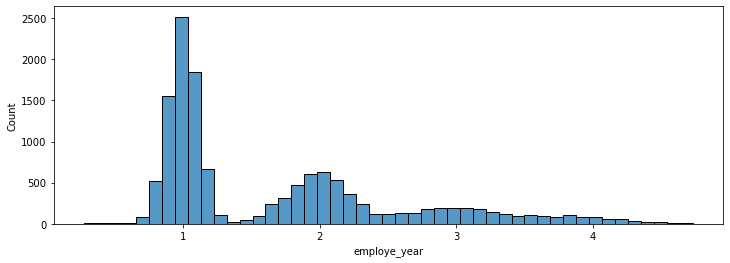

In [36]:
plt.figure(figsize = (12, 4))
sns.histplot(data = data, x = 'employe_year')
plt.show()

##### 2) quit vs quit_month

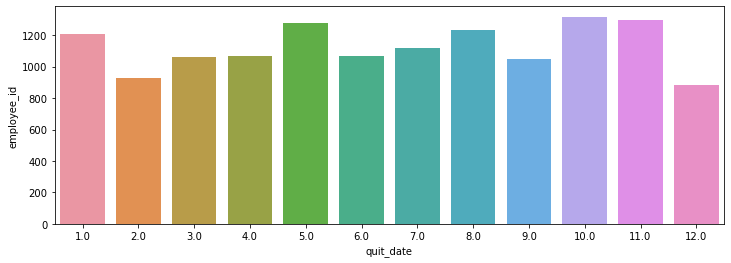

In [66]:
temp_data = data.groupby(data['quit_date'].dt.month)['employee_id'].count().reset_index()
plt.figure(figsize = (12, 4))
sns.barplot(data = temp_data, x = 'quit_date', y = 'employee_id')
plt.show()

##### 3) quit VS quit_week

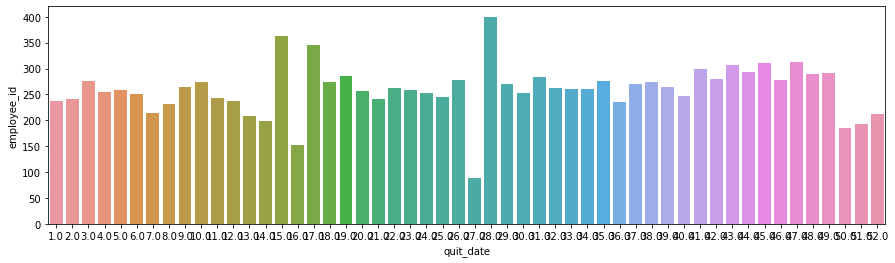

In [69]:
temp_data = data.groupby(data['quit_date'].dt.week)['employee_id'].count().reset_index()
plt.figure(figsize = (15, 4))
sns.barplot(data = temp_data, x = 'quit_date', y = 'employee_id')
plt.show()

##### 4) quit VS seniority

In [46]:
data['employe_year_before_quit']  = round(data['employe_year'],0) + data['seniority']

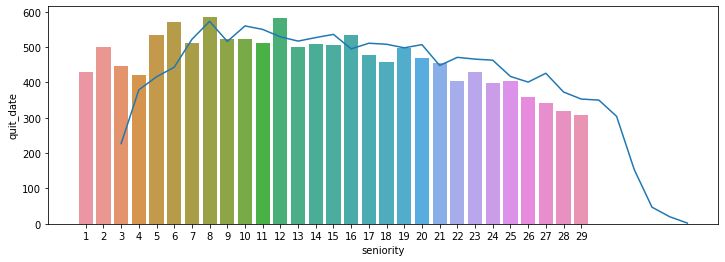

In [51]:
temp_data = data.groupby('seniority')['quit_date'].count().reset_index()
temp_data_before_quit = data.groupby('employe_year_before_quit')['employee_id'].count().reset_index()

plt.figure(figsize = (12, 4))
sns.barplot(data = temp_data, x = 'seniority', y = 'quit_date')
sns.lineplot(data = temp_data_before_quit, x = 'employe_year_before_quit', y = 'employee_id' ) 
plt.show()

##### we explore the relationship between seniority or total employee year before quit with the quit numbers. We found that working experiences less than 15 years are more likely to quit.

#### 5) quit vs salary

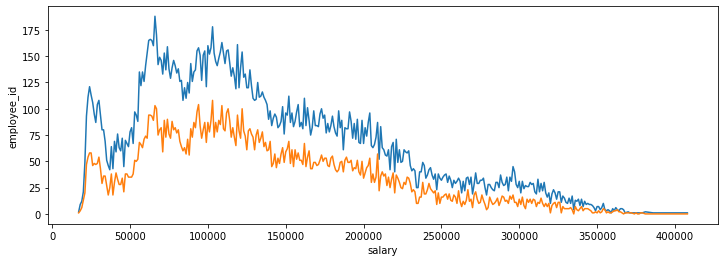

In [55]:
temp_data_quit = data.groupby('salary')['quit_date'].count().reset_index()
temp_data_employee = data[['salary', 'employee_id']].groupby(['salary']).count().reset_index()

plt.figure(figsize = (12, 4))

sns.lineplot(data = temp_data_employee, x = 'salary', y = 'employee_id')
sns.lineplot(data = temp_data_quit, x = 'salary', y = 'quit_date')
plt.show()

###### we explore the relationship of salary any quit, we notice that the salary distribution in all employees and in quit employees are similar, which means most of people concentrate in the range of [60000, 125000] People who earns more or less than this range are less likely to quit.

### Part 3 verify the explore conclusion with a decision tree model

In [72]:
data.head(3)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employe_days,employe_year,employe_year_before_quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,1.602740,30.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,0.931507,21.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,NaN,NaN


In [73]:
data.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'employe_days', 'employe_year',
       'employe_year_before_quit'],
      dtype='object')

In [77]:
reg_data = data[['company_id', 'dept', 'seniority', 'salary', 'quit_date', 'employe_year']]
reg_data['quit'] = reg_data['quit_date'].isna()
reg_data = pd.get_dummies(reg_data, columns = ['company_id', 'dept', 'quit'], drop_first = True)
reg_data.columns

Index(['seniority', 'salary', 'quit_date', 'employe_year', 'company_id_2',
       'company_id_3', 'company_id_4', 'company_id_5', 'company_id_6',
       'company_id_7', 'company_id_8', 'company_id_9', 'company_id_10',
       'company_id_11', 'company_id_12', 'dept_data_science', 'dept_design',
       'dept_engineer', 'dept_marketing', 'dept_sales', 'quit_True'],
      dtype='object')

In [82]:
X_train = reg_data[['seniority', 'salary', 'company_id_2',
       'company_id_3', 'company_id_4', 'company_id_5', 'company_id_6',
       'company_id_7', 'company_id_8', 'company_id_9', 'company_id_10',
       'company_id_11', 'company_id_12', 'dept_data_science', 'dept_design',
       'dept_engineer', 'dept_marketing', 'dept_sales']]
y_train = reg_data['quit_True']

fullClassTree = DecisionTreeClassifier(random_state=1, max_depth = 8)
fullClassTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=1)

In [84]:
for importance, name in sorted(zip(fullClassTree.feature_importances_, X_train.columns),reverse=True):
    print (name, importance)

salary 0.5887034865070834
seniority 0.17742906296676525
company_id_2 0.036930636237872475
company_id_4 0.031057345818112172
company_id_5 0.022992383520847228
company_id_10 0.021257942430191298
company_id_6 0.018985773283936427
dept_data_science 0.017880903009807887
company_id_7 0.01777388846660181
dept_engineer 0.016363583010795994
company_id_3 0.015871197124321192
company_id_9 0.009668545949825979
company_id_8 0.0077319386325751405
dept_marketing 0.00556546717982912
dept_design 0.003986878100785995
company_id_12 0.002814563983278477
company_id_11 0.0027872132538727663
dept_sales 0.002199190523497525
